In [11]:
# import Python packages
from pathlib import Path
import numpy as np
import re
import os
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gpd
import seaborn as sns
from matplotlib_scalebar.scalebar import ScaleBar
from geodatasets import get_path

from scipy import stats
import warnings
from sklearn.metrics import ConfusionMatrixDisplay
warnings.filterwarnings('ignore')
import matplotlib.colors as mcolors
import xml.etree.ElementTree as ET

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.size'] = 24

# load event data

In [12]:
data = pd.read_csv('aEQgate_geometries.csv')
EQ = data["Earthquake"].unique()

data_dir = Path('/Users/adminalba/Documents/EQ_gates/Matlab_code/')
event_info = pd.read_csv(data_dir/'FDHI_data/event_info.txt',delimiter='\t')

# load rupture shapefiles

In [13]:
# Create an empty GeoDataFrame to store the loaded data
rupture_directory = 'event_kmz/'
gdf_ruptures = gpd.GeoDataFrame()

# List all files in the directory
for filename in os.listdir(rupture_directory):
    if filename.endswith(".shp"):  # Check if the file is a shapefile
        # Load the shapefile and append it to the GeoDataFrame
        filepath = os.path.join(rupture_directory, filename)
        gdf_ruptures = gdf_ruptures.append(gpd.read_file(filepath))


In [14]:
data['Earthquake'].unique()

array(['Balochistan', 'Borrego', 'ChalfantValley', 'Darfield', 'Denali',
       'Duzce', 'ElmoreRanch', 'GalwayLake', 'HectorMine', 'Hualien',
       'Imperial1940', 'Imperial1979', 'Izmit_Kocaeli', 'IzuPeninsula',
       'Kobe', 'Kumamoto', 'Landers', 'Luzon', 'Napa', 'Neftegorsk',
       'Parkfield1966', 'Parkfield2004', 'Pisayambo', 'Ridgecrest1',
       'Ridgecrest2', 'SanMiguel', 'SuperstitionHills', 'Yushu', 'Yutian',
       'Zirkuh', 'IzuOshima'], dtype=object)

# load EQ gate shapefiles

In [15]:
EQgate_directory = data_dir / 'primary_EQgate_shapefiles_v1'
gdf_EQgates = gpd.GeoDataFrame()
shapefile_names = []

for filename in os.listdir(EQgate_directory):
    if filename.endswith(".shp"): 
        # Load the shapefile and append it to the GeoDataFrame
        filepath = os.path.join(EQgate_directory, filename)
        gdf_EQgates = gdf_EQgates.append(gpd.read_file(filepath))
        shapefile_names.append(filename)

In [16]:
# Define dictionary for color-coding EQ gate shapefiles
color_mapping = {
    'stepover_breached': 'forestgreen',
    'stepover_unbreached': 'firebrick',
    'bend_breached': 'cornflowerblue',
    'bend_unbreached': 'darkorange',
    'strand_breached': 'purple',
    'splay_breached': 'darkseagreen',
    'splay_unbreached': 'peru',
    'gap_breached': 'olive',
    'gap_unbreached': 'orangered'
}

# load regional maps

In [17]:
Qfaults = gpd.read_file(data_dir / 'Regional_maps/Qfaults_cut_fdhi.shp')
Asiamap = gpd.read_file(data_dir / 'Regional_maps/cropAFEAD.shp')
NZmap = gpd.read_file(data_dir / 'Regional_maps/NZAFD_Oct_2020.shp')
Worldmap = gpd.read_file(data_dir / 'Regional_maps/GEM_cut_FDHI.shp')

In [18]:
basemap_dict = {
    'Qfaults':  data_dir / 'Regional_maps/Qfaults_cut_fdhi.shp',
    'AFEAD': data_dir / 'Regional_maps/AFEAD_v2021.shp',
    'NZ': data_dir / 'Regional_maps/NZAFD_Oct_2020.shp',
    'GEM': data_dir / 'Regional_maps/GEM_cut_FDHI.shp'
}

# plot maps for each event

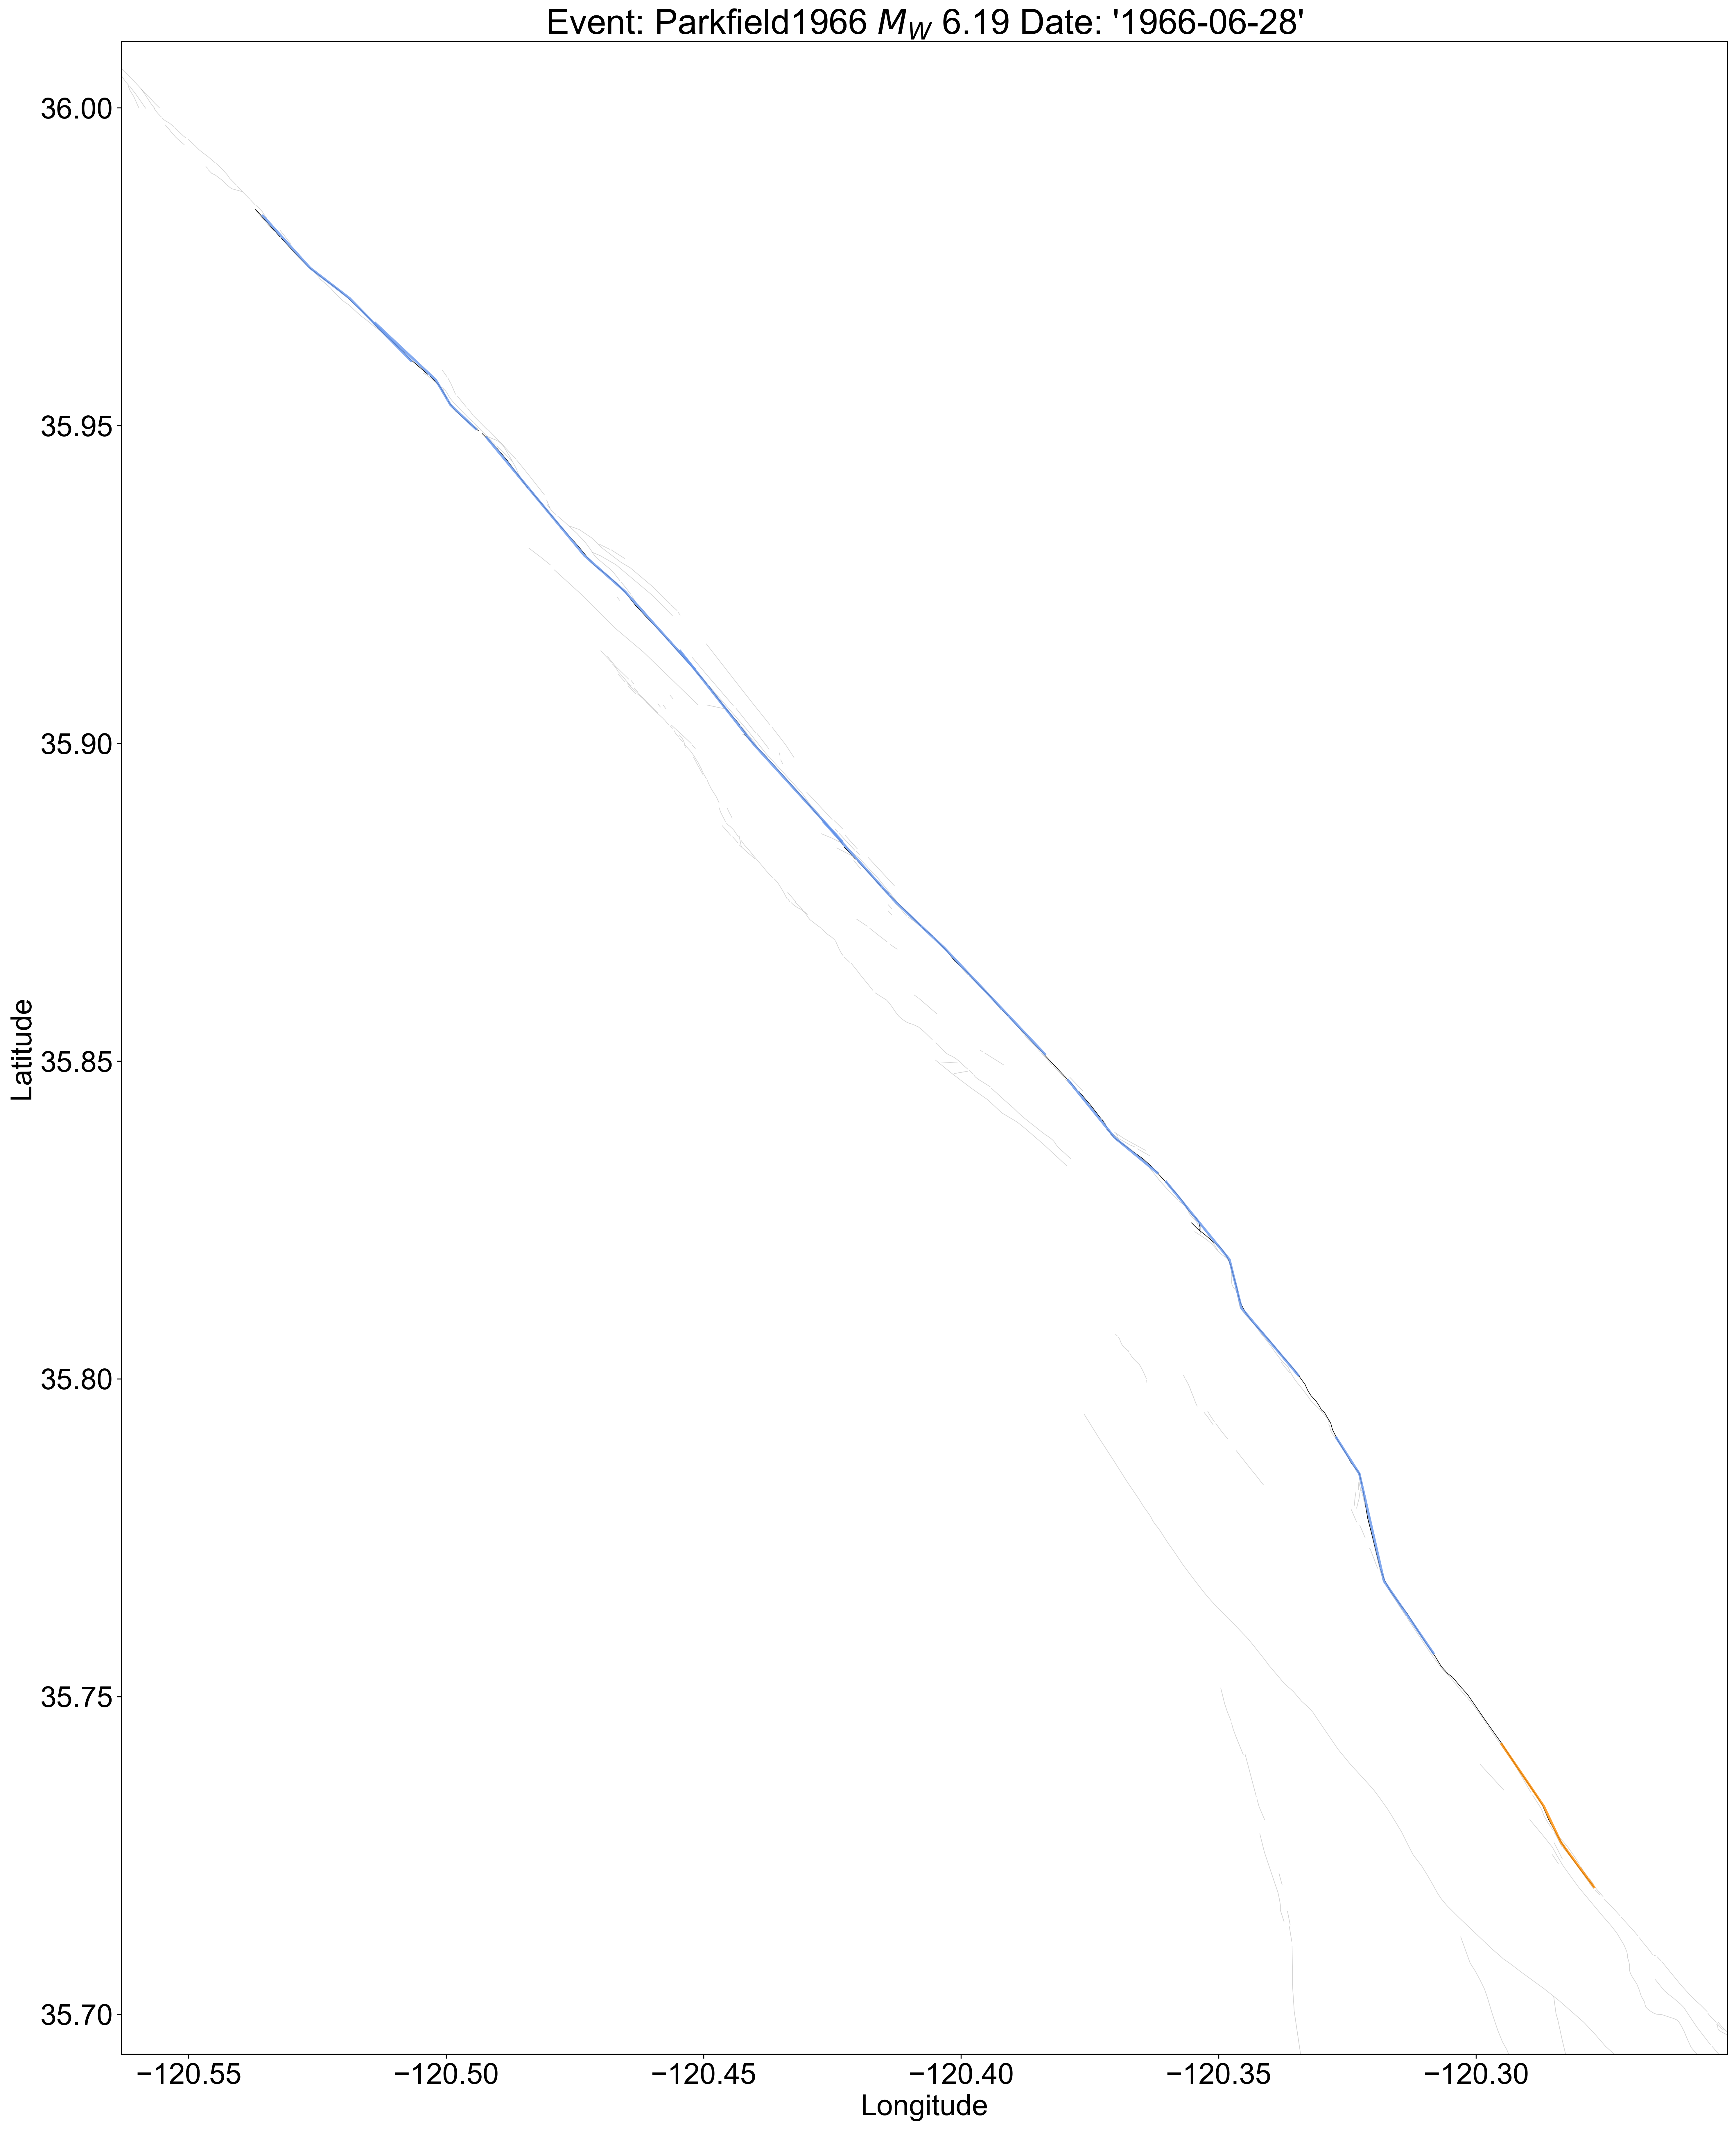

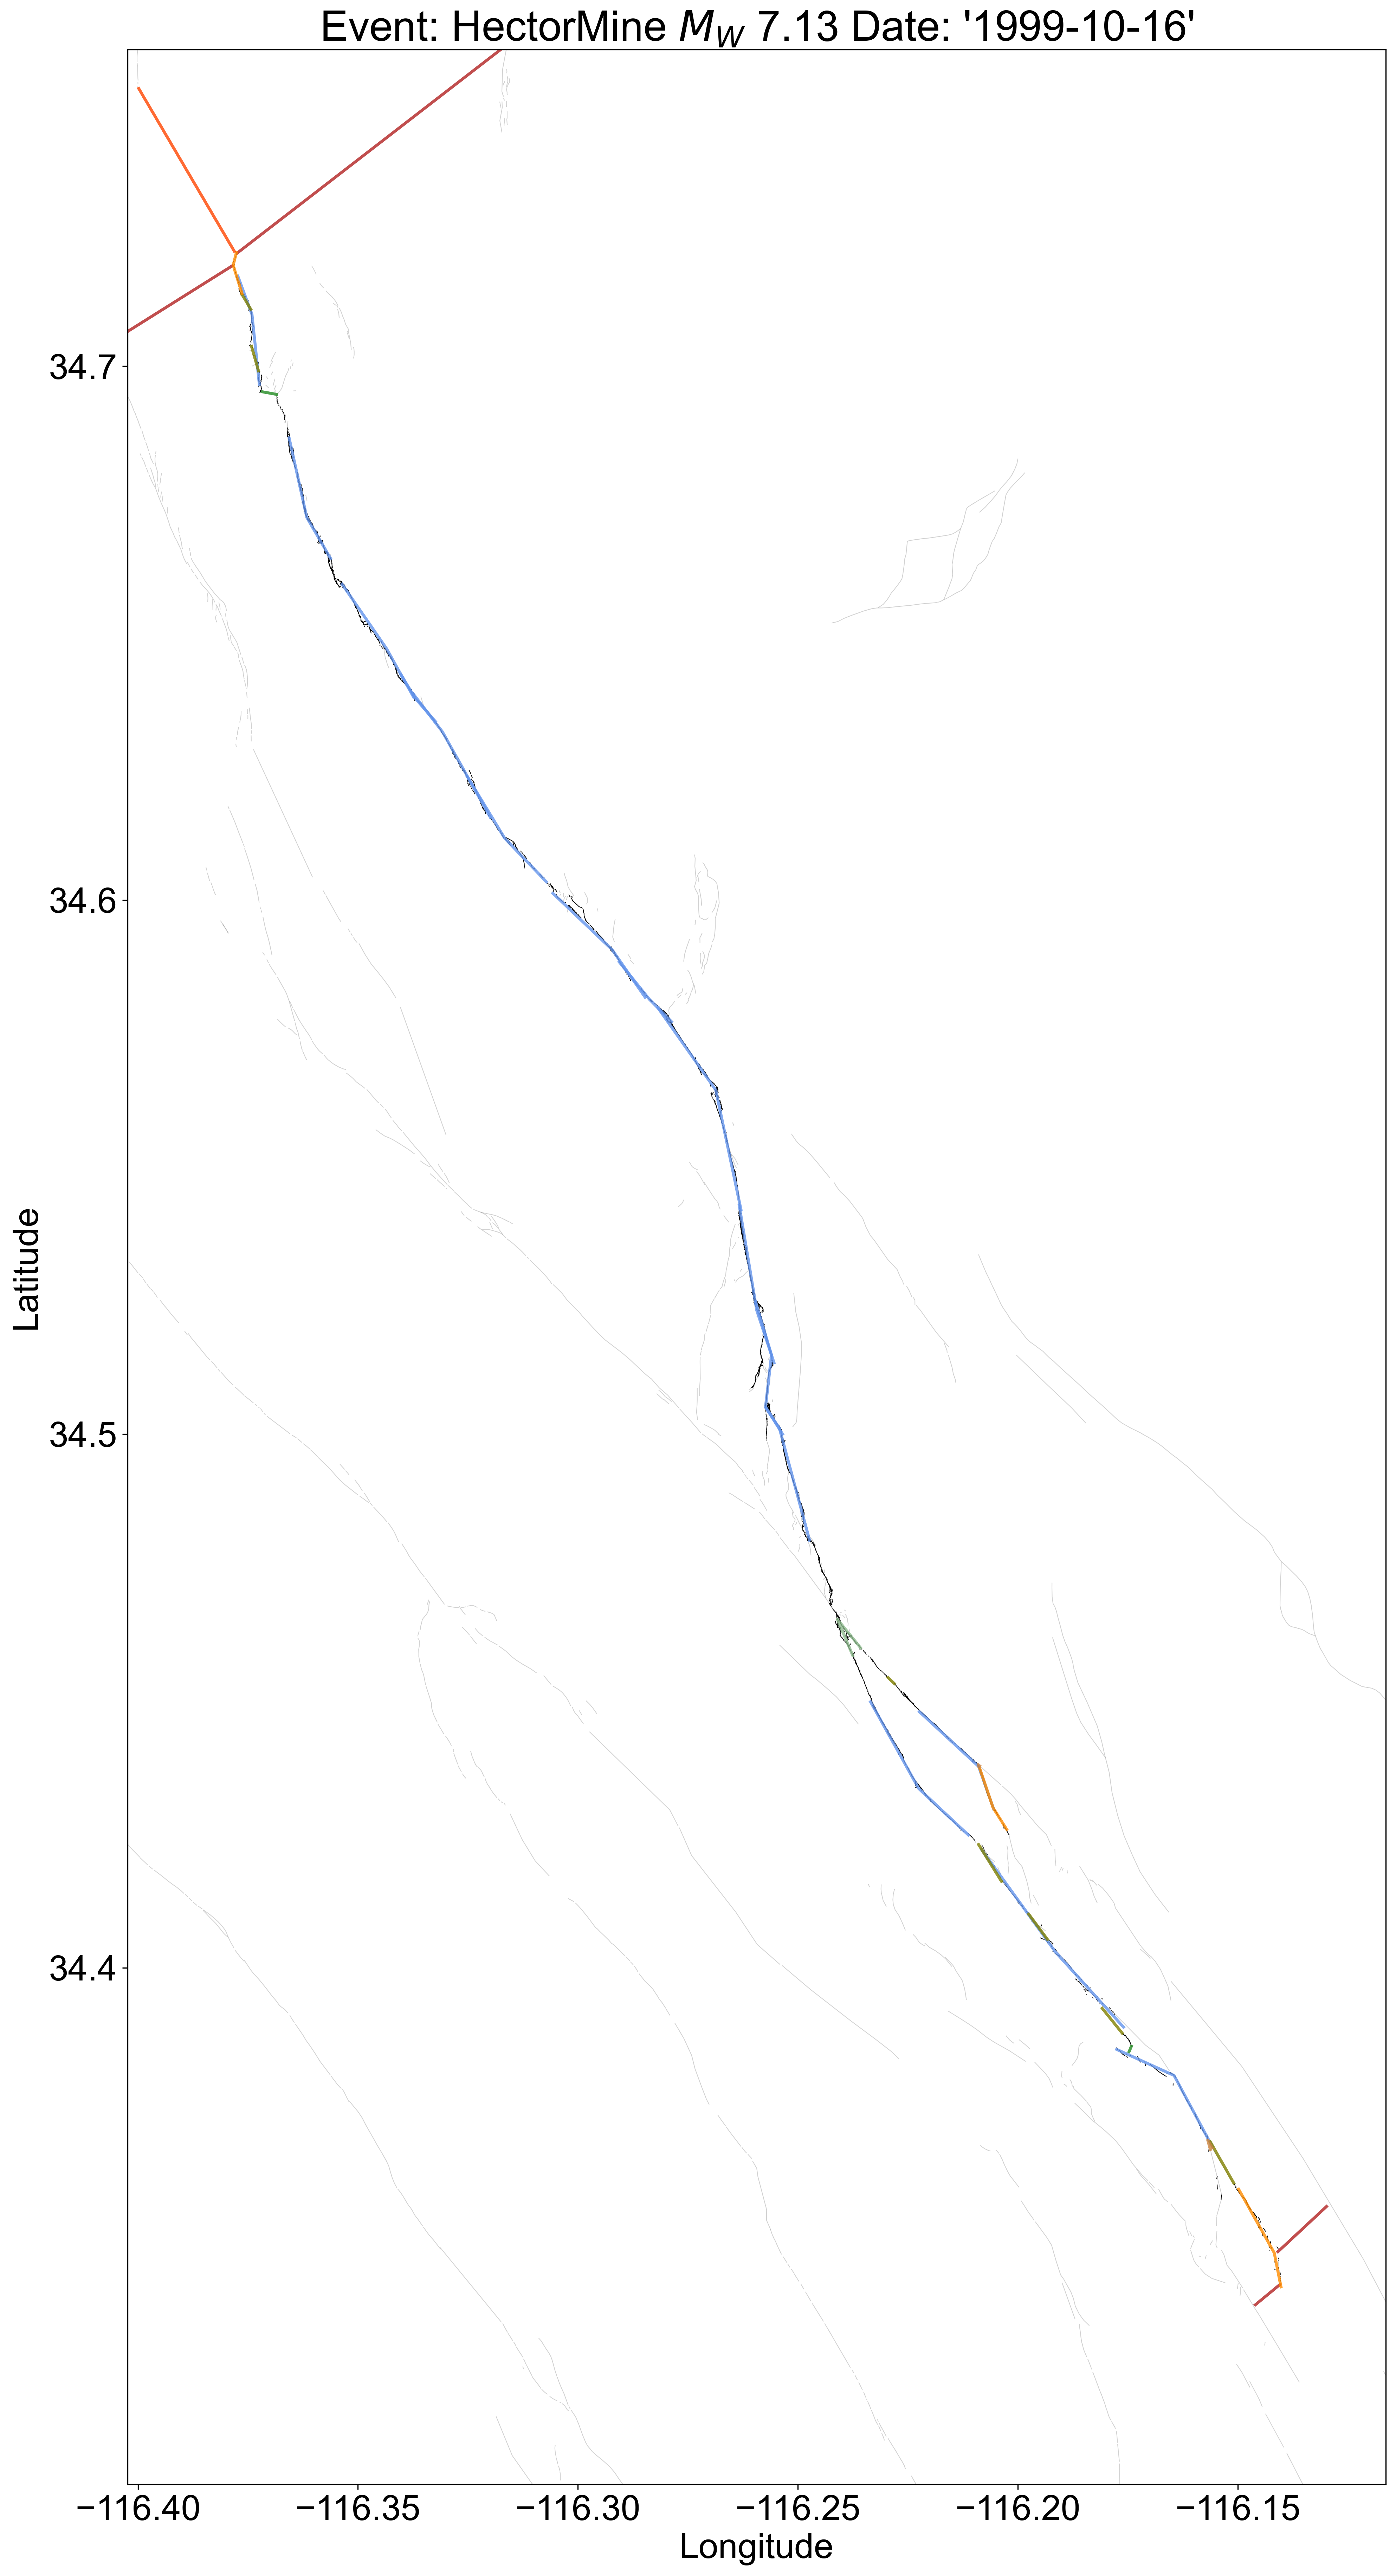

DriverError: Unable to open /Users/adminalba/Documents/EQ_gates/Matlab_code/Regional_maps/AFEAD_v2021.shx or /Users/adminalba/Documents/EQ_gates/Matlab_code/Regional_maps/AFEAD_v2021.SHX. Set SHAPE_RESTORE_SHX config option to YES to restore or create it.

<Figure size 9000x9000 with 0 Axes>

In [19]:
gdf_ruptures['first_segment'] = gdf_ruptures['Name'].str.split('_').str[0]
gdf_EQgates = gpd.GeoDataFrame()
unique_segments = gdf_ruptures['first_segment'].unique()

for segment in unique_segments:
    plt.figure(figsize=(30,30), dpi=300)

    matching_rows_basemap = event_info[event_info['event'] == segment]
    if segment == 'Izmit':
        matching_rows_data = data[data['Earthquake'] == 'Izmit_Kocaeli'] # account for name difference in two spreadsheets
    else:
        matching_rows_data = data[data['Earthquake'] == segment]

    date = matching_rows_data['Date'].values[0]
    magnitude = matching_rows_data['Magnitude'].values[0]
    basemap_key = matching_rows_basemap['region']
    region_values = ''.join(basemap_key)
    epsg = matching_rows_basemap['geocode']

    if region_values in basemap_dict:
        shapefile_path = basemap_dict[region_values]
        gdf = gpd.read_file(shapefile_path)
        gdf.plot(ax=plt.gca(), color='dimgray', alpha=0.3, linewidth=0.5)

    subset_gdf_ruptures = gdf_ruptures[gdf_ruptures['first_segment'] == segment]
    subset_gdf_ruptures.plot(ax=plt.gca(), color='black', linewidth=0.5)
    x_min, y_min, x_max, y_max = subset_gdf_ruptures.geometry.total_bounds

    x_padding = 0.1 * (x_max - x_min)
    y_padding = 0.1 * (y_max - y_min)
    for filename in os.listdir(EQgate_directory):
        gdf_matching_shapefiles = gpd.GeoDataFrame()
        if filename.endswith(".shp") and segment in filename:
            filepath = os.path.join(EQgate_directory, filename)
            gdf_matching_shapefile = gpd.read_file(filepath)
            if not gdf_matching_shapefile.empty:
                gdf_matching_shapefiles = gdf_matching_shapefiles.append(gdf_matching_shapefile)
                key = "_".join(filename.split('_')[:2])
                if key in color_mapping:
                    gdf_matching_shapefiles.plot(ax=plt.gca(),color=color_mapping[key], linewidth=2,alpha=0.8)

    plt.xlim(x_min - x_padding, x_max + x_padding)
    plt.ylim(y_min - y_padding, y_max + y_padding)
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    title = r"Event: " + segment + " $M_W$ " + str(magnitude) + " Date: " + date
    plt.title(title)
    file_path = "pdf_maps/" + segment

    # subset_gdf_ruptures.crs = 'EPSG:4326'  # Set the CRS to WGS 84
    # epsglines = subset_gdf_ruptures.to_crs(int(epsg))

    # distance_meters = epsglines.iloc[0].geometry.distance(epsglines.iloc[1].geometry)
    # # Apply the to_crs method to the 'nybb' GeoDataFrame
    # nybb = gpd.read_file(get_path("nybb"))
    # nybb = nybb.to_crs(4326) 

    # plt.gca().add_artist(ScaleBar(distance_meters))

    plt.savefig(f"{file_path}.pdf") 
    plt.show()


# Legend plot

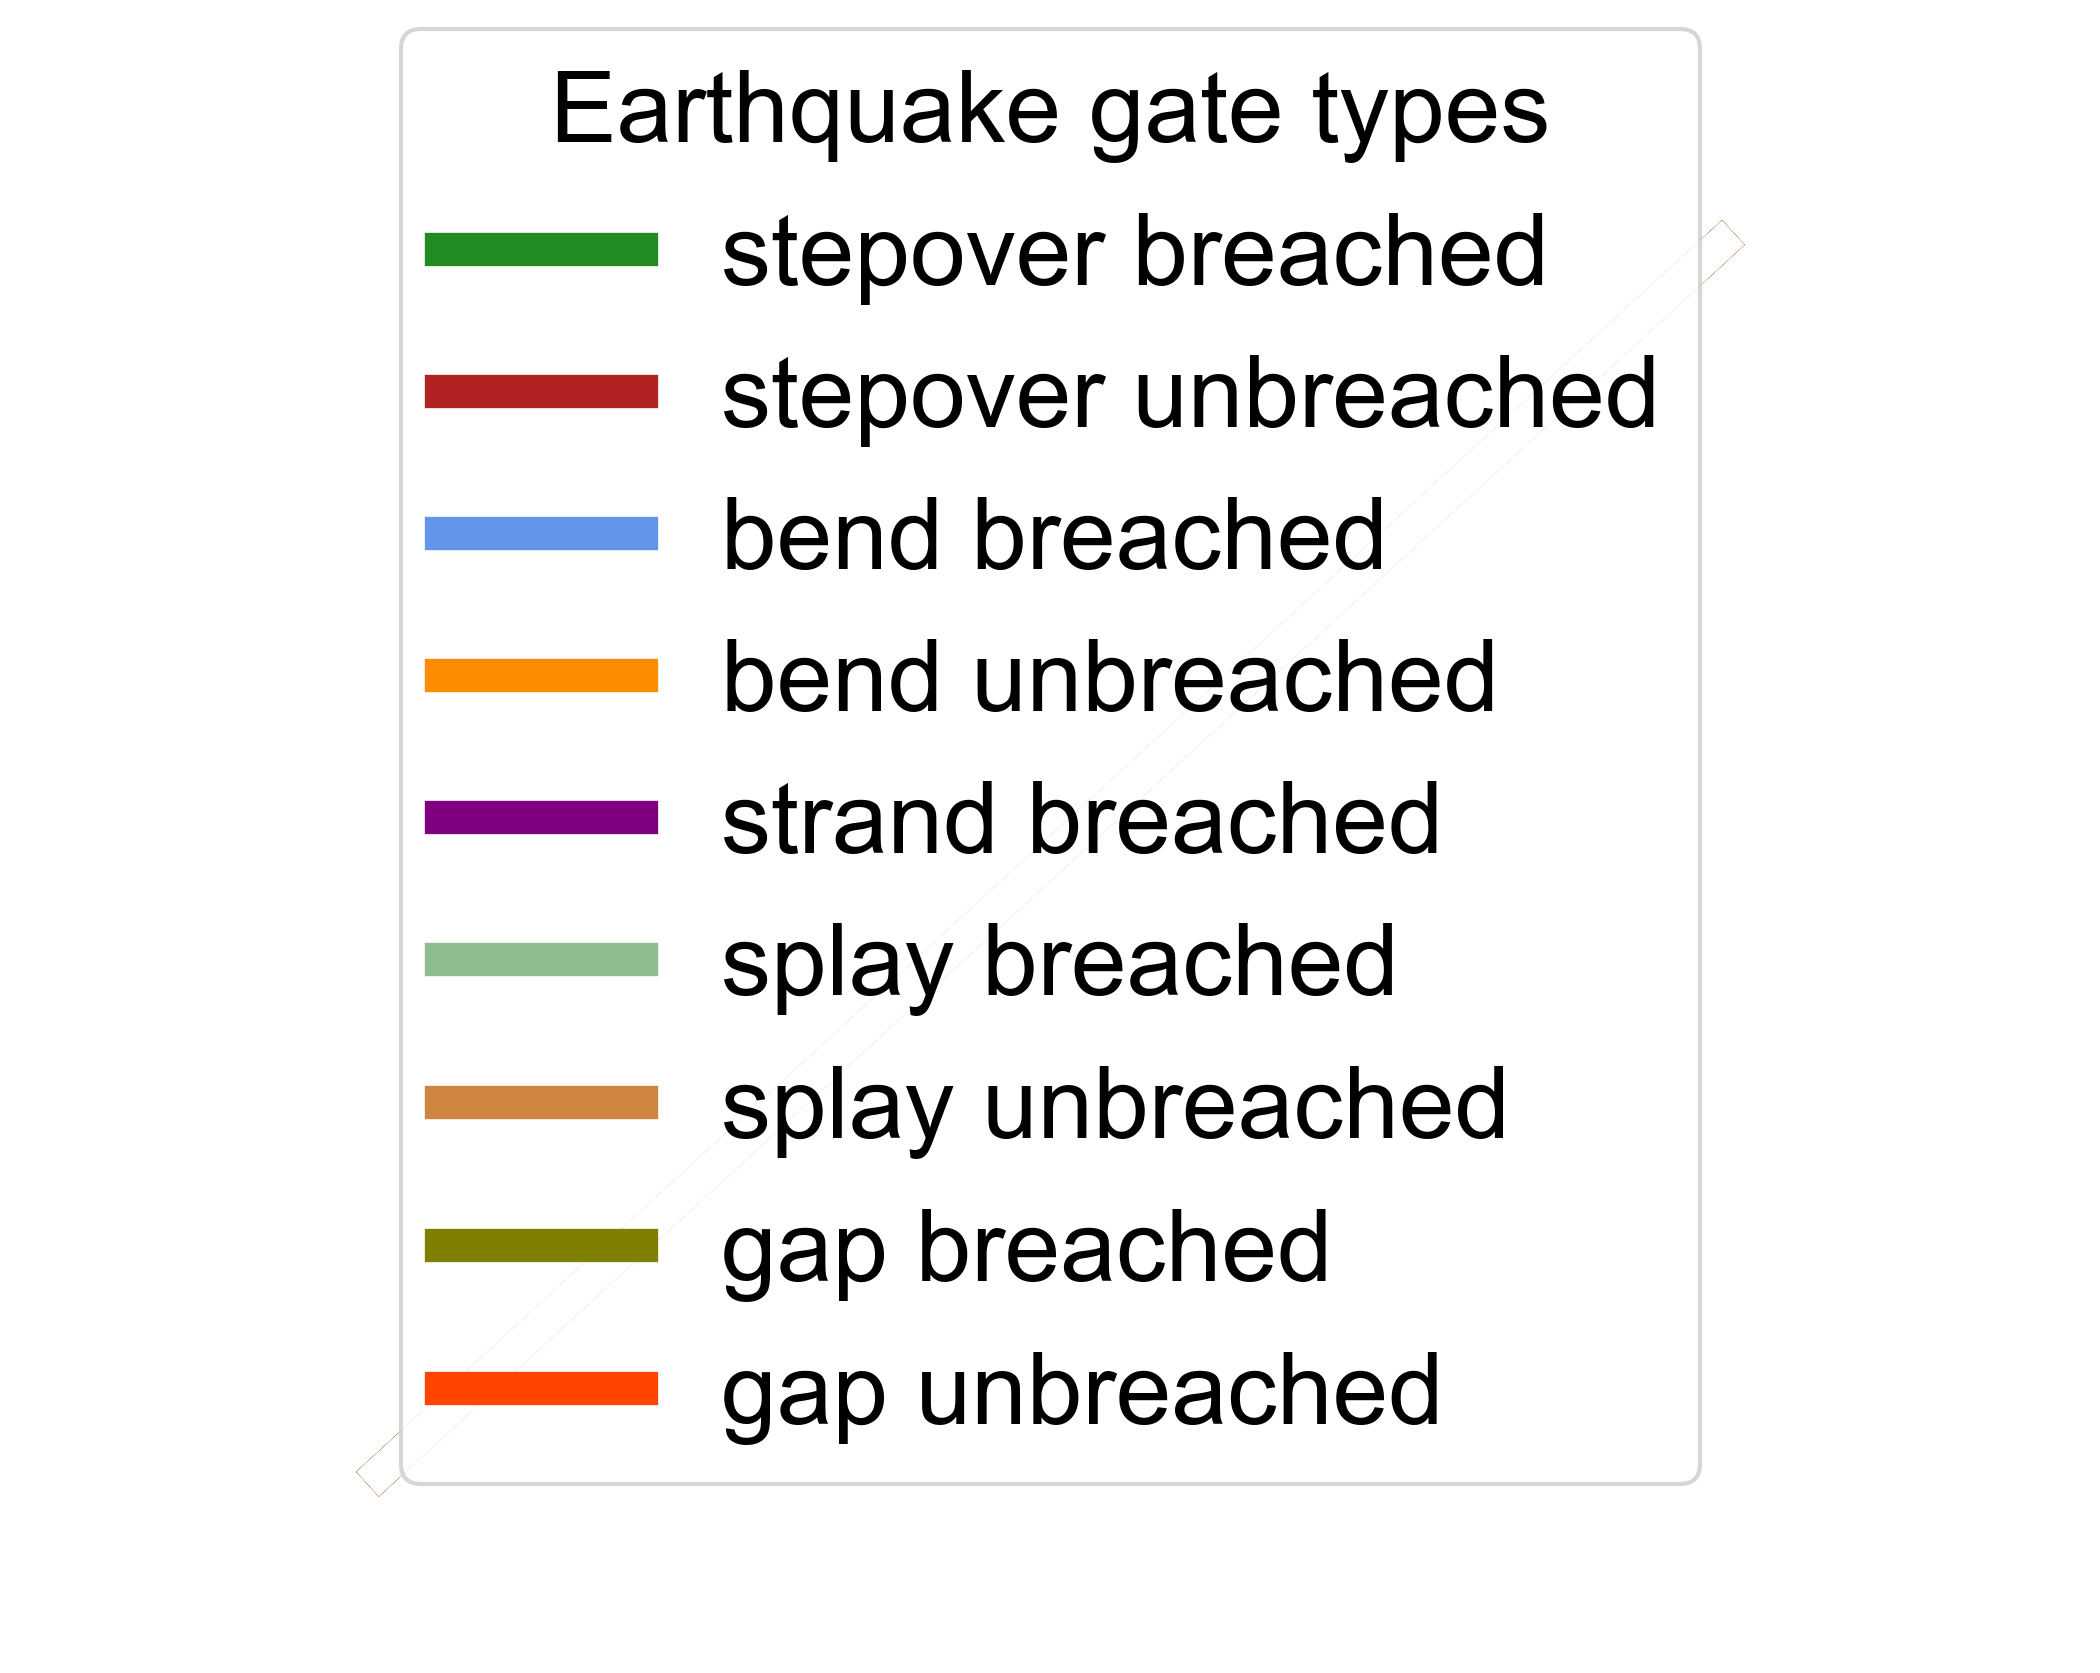

In [ ]:


# Extract keys and values from the dictionary
categories = list(color_mapping.keys())
colors = list(color_mapping.values())

# Create a line plot with lines colored based on the dictionary
plt.figure(figsize=(6, 6), facecolor='white')  # Set the background color to white

for category, color in zip(categories, colors):
    plt.plot([0, 1], [0, 1], label=category, color=color, linewidth=8)

plt.plot([0, 1], [0, 1], label=category, color='white',linewidth=8)
# Customize the plot
plt.title('Line Plot with Color-Coded Categories', color='white')
plt.xlabel('X-Axis', color='white')
plt.ylabel('Y-Axis', color='white')

# Remove ticks and tick labels on both X and Y axes
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

# Replace underscores with spaces in legend labels
legend_labels = [category.replace('_', ' ') for category in categories]


# Make the x and y axis lines white
plt.gca().spines[['left', 'bottom']].set_color('white')
plt.gca().spines[['top', 'right']].set_color('none')

# Place the legend outside the plot
plt.legend(legend_labels,title='Earthquake gate types')
plt.tight_layout()
plt.savefig('pdf_maps/legend_EQgates.pdf')
# Show the plot
plt.show()
